# Introduction

In this notebook, we will be creating a real time visualization of Manhattan traffic using sensor data from [this URL](http://207.251.86.229/nyc-links-cams/LinkSpeedQuery.txt) at the [NYC DOT website](http://www.nyc.gov/html/dot/html/about/datafeeds.shtml).  The URL updates "several times per minute" according to the [documentation](http://a841-dotweb01.nyc.gov/datafeeds/TrafficSpeed/metadata_trafficspeeds.pdf).  Because of this, we'll plug it into Spark Streaming and Geoff Boeing's [osmnx package](https://github.com/gboeing/osmnx) for street networks.

This side project evolved from a Spark Streaming project I had in grad school after stumbling across the release of [osmnx](https://github.com/gboeing/osmnx)  during a winter break.  This package allows for far more in-depth applications than what I'm using it for, and I highly recommend checking it out if you have any projects involving street networks.

While this could be accomplished in regular Python (and this application isn't particularly useful), I'm hoping this will aid those looking to use PySpark for Spark Streaming.  Aside from the [documentation](http://spark.apache.org/docs/latest/api/python/pyspark.streaming.html) and [official programming guide](http://spark.apache.org/docs/latest/streaming-programming-guide.html), there aren't a lot of examples of Spark Streaming using PySpark available, as most are in Scala.

Before we go into the details, I wanted to give a brief overview of Spark Streaming.  Like regular Spark, it is used for processing the data - not generating or storing it.  It is very similar to regular Spark, but is designed to be able to handle constantly updating data.  Here is an abstract graphical representation of the process:

<img src="http://spark.apache.org/docs/latest/img/streaming-flow.png">

Here is a more realistic representation that further showcases its role in an ecosystem with other tools.  In this example, we will be using the Spark SQL component in order to convert our DStreams into a data frame in order to utilize operations from pandas:

<img src="http://2s7gjr373w3x22jf92z99mgm5w-wpengine.netdna-ssl.com/wp-content/uploads/2015/11/spark-streaming-datanami.png">

Spark Streaming is arguably not even real streaming when you get into the details.  Specifically, it ingests the data in a series of micro batches (that update at specified intervals) referred to as DStream objects. Because the DStream is updated at set intervals, it is not technically "real time".  DStream objects are a series of RDDs at their core, and there are a lot of similar operations between them:

<img src="https://image.slidesharecdn.com/apachesparkhs-141212054258-conversion-gate01/95/apache-spark-streaming-46-638.jpg?cb=1418381382">

Spark Streaming ingests data in three ways:

**1)** From another source like Kafka, Flume, etc.

**2)** From a web socket

**3)** From text files

I'm running Spark on my local Windows machine, so I'm going to go with the text file option.  It sounds easy enough at first, but has one hangup: Spark Streaming will not pick up the text files unless they are newly generated *after* the Spark streaming context starts. Therefore, we have to run it in combination with [this script](https://github.com/JeffMacaluso/Blog/blob/master/StreamingNYC/WebScraper.ipynb) that uses the requests library to grab data from the web.

From there, we will read the data into a DStream with a Streaming context, and then register it as a temporary table in the SQL context in order to extract it to a pandas data frame.  There is a fair amount of manipulation required for the data in order to get it to the exact format we want before plotting it, so the pandas operations makes this easier.  Lastly, we will plot the speed at the individual sensors on the city map.

# Set Up

Before getting to the fun stuff, we have to set up a few things first:

- Set up Spark & Spark contexts
- Import other libraries
- Set up the road network
- Map the latitude/longitude points to nodes on the road network


We'll start with assigning a couple of options to variables in order to make it easier to change in the future.

In [1]:
# Where the web scraper script is outputting files
streamFilePath = "file:/C:/Users/JeffM/Documents/Projects/Spark Streaming/Data/"

# Number of seconds for Spark to ingest the data files
microBatchSeconds = 30

### Set up Spark & Spark contexts

Since I'm running Spark on my local Windows machine, I have to do a few additional steps to make it play nicely with Jupyter Notebooks:

In [2]:
import os
import sys

# Set the path for the Spark folder
sparkPath = "C:/Users/JeffM/Documents/Spark/spark-2.0.2-bin-hadoop2.7"

os.environ['SPARK_HOME'] = sparkPath
sys.path.append(sparkPath + '/bin')
sys.path.append(sparkPath + '/python')
sys.path.append(sparkPath + '/python/pyspark' "C:/Spark/python/pyspark")
sys.path.append(sparkPath + '/python/pyspark/lib')
sys.path.append(sparkPath + '/python/pyspark/lib/pyspark.zip')
sys.path.append(sparkPath + '/python/pyspark/lib/py4j-0.10.3-src.zip')
sys.path.append("C:/Program Files/Java/jre1.8.0_111/bin")

This next part sets up the actual contexts for Spark.  We have three separate contexts here:

1) SparkContext

2) StreamingContext

3) SQLContext

In [3]:
import pyspark
from pyspark.streaming import StreamingContext

sc = pyspark.SparkContext("local[2]", "trafficData")  # Local[#] sets # of cores to use
ssc = StreamingContext(sc, microBatchSeconds)  # Seconds per micro-batch
sqlContext = pyspark.SQLContext(sc)

### Import other libraries

In [4]:
# Data manipulation
import pandas as pd
import numpy as np

# Timestamps
from datetime import datetime, timedelta

# City network and plots
import osmnx as ox, geopandas as gdp
import matplotlib.pyplot as plt

# To replace output plots for streaming
from IPython import display

# Sets intervals for updating the plot
import time

%matplotlib inline

### Set up the road network

If you are familiar with [graph theory](https://en.wikipedia.org/wiki/Graph_theory), the road networks in the [osmnx package](https://github.com/gboeing/osmnx) are a series of nodes and edges.  We will map our sensors to nodes in the network using their longitude/latitude locations, but we first have to create the actual network.

Osmnx fortunately has a variety of methods to create a road network (in addition to other networks like bike networks and walking networks).  Here, we'll use the "graph_from_place" method.

We are then going to [project](https://en.wikipedia.org/wiki/Map_projection) our network in order to get a top-down view of Manhattan.  I'll include plots of the projected and non-projected versions to clarify this concept.

In [5]:
# Retrieving the network for Manhattan
manhattan = ox.graph_from_place('Manhattan, New York, USA', network_type='drive')

# Projecting the network for a top-down view
manhattan_projected = ox.project_graph(manhattan)

Non-projected:


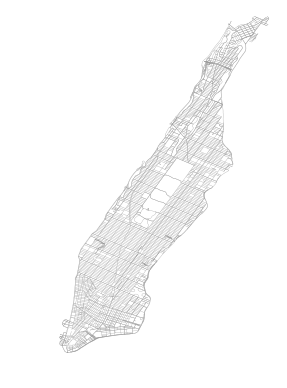

Projected:


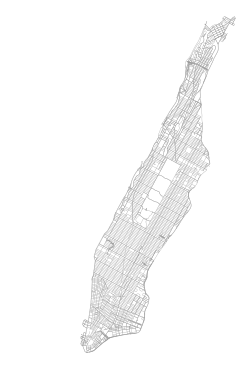

In [6]:
print('Non-projected:')
fig1 = ox.plot_graph(manhattan, fig_height=4.5, node_size=0, 
              node_alpha=1,edge_linewidth=0.2, dpi=100)

print('Projected:')
fig2 = ox.plot_graph(manhattan_projected, fig_height=4.5, node_size=0, 
              node_alpha=1,edge_linewidth=0.2, dpi=100)

### Map the latitude/longitude points to nodes on the road network

In order to match up our streaming data to the city network, we're going to have to find the corresponding network node for each sensor using its latitude/longitude points.  We're going to do this before we begin streaming by using a template (any of the files generated from the web scraping script - the date or time don't matter).  

We're doing this here so we can just join this data frame to the streaming data in order to avoid re-calculating which node belongs to each sensor every time we receive new streaming data.  This is possible due to having a set amount of sensors with static locations and ids.

In [7]:
# Importing only the fields we're interested in
dfNodes = pd.read_csv('trafficDataTemplate.txt',
            usecols=[0, 6, 11],
            names=['id', 'linkPoints', 'borough'])

# Filtering to Manhattan and dropping the borough column
dfNodes = dfNodes[dfNodes['borough'] == 'Manhattan']
dfNodes = dfNodes[['id', 'linkPoints']]

# Splitting the column containing all Lat/Long combinations
dfNodes['splitPoints'] = dfNodes['linkPoints'].apply(lambda x: x.split(' '))

# Reshaping our data frame to have a row for each Lat/Long point
idNodes = []
for x,y in zip(dfNodes['splitPoints'], dfNodes['id']):
    for a in np.arange(len(x)):
        idNodes.append((y, x[a]))
dfNodes = pd.DataFrame(idNodes, columns=['id', 'LatLong'])

dfNodes = dfNodes.replace('', np.NaN).dropna()

# Parsing Lat/Long into individual columns
# Longitude has an if statement since some records contain '-' for longitude
dfNodes['Latitude'] = dfNodes['LatLong'].apply(lambda x: x.split(';')[0])
dfNodes['Longitude'] = dfNodes['LatLong'] \
    .apply(lambda x: x.split(';')[1] if len(x.split(';')) > 1 else None)

# Dropping incorrect longitude records and converting everything to floats
dfNodes = dfNodes[dfNodes['Longitude'] != '-'][['id', 'Latitude', 'Longitude']].astype(float)

# Obtaining the nearest nodes in the network from the Lat/Long points
nodes = []
for row in dfNodes.iterrows():
    nearest_node = ox.get_nearest_node(manhattan, (dfNodes['Latitude'].ix[row], 
                                                   dfNodes['Longitude'].ix[row]))
    nodes.append(nearest_node)
dfNodes['Node'] = nodes

# Removing duplicate nodes
dfNodes.drop_duplicates(subset='Node', inplace=True)

dfNodes.head()

,id,Latitude,Longitude,Node
0,2.0,40.73933,-74.010040,593816275
1,2.0,40.73895,-74.010120,246649429
2,2.0,40.73760,-74.010021,42439099
3,2.0,40.73460,-74.010260,42453468
4,2.0,40.72912,-74.010781,246857084


# Streaming

This section will do the actual streaming.  It needs to be run in parallel with the web scraping script in order to continuously update the data folder with new files.  As a reminder, Spark Streaming will not continuously re-read a file, and will only stream new files placed into a location.

Our process here is to read the files using the streaming context and register them in the SQL context as a temporary table.  Once it's in a temporary table, we can pull it out into a pandas data frame, perform additional manipulation, and finally plot it.

### Indexes

Taken directly from the [documentation](http://a841-dotweb01.nyc.gov/datafeeds/TrafficSpeed/metadata_trafficspeeds.pdf)

0) **Id**: TRANSCOM Link ID

1) **Speed**: Average speed a vehicle traveled between end points on the link in the most recent interval

2) **TravelTime**: Time the average vehicle took to traverse the link

3) **Status**: Artifact - not useful

4) **DataAsOf**: Last time data was received from link

5) **linkId**: TRANSCOM Link ID (same as ID field)

6) **linkPoints**: Sequence of Lat/Long points, describes locations of the senosr links.  Google compatible polyline form.

7) **EncodedPolyLine**: http://code.google.com/apis/maps/documentation/polylineutility.html  Google compatible poly levels form.

8) **EncodedPolyLineLvls**: http://code.google.com/apis/maps/documentation/polylineutility.html

9) **Owner**: Owner of the Detector

10) **Transcom_id**: Artifact - Not Useful

11) **Borough**: NYC borough Brooklyn, Bronx, Manhattan, Queens, Staten Island

12) **linkName**: Description of the link location and end points

In [8]:
# Reads files from the specified path
trafficStream = ssc.textFileStream(streamFilePath).map(lambda line: line.split(',')) \
                   .filter(lambda line: line[11] == 'Manhattan')  # Removes other boroughs

# Puts specified columns into a temporary table
trafficStream.map(lambda line: (line[0], line[1], line[4], line[6], line[11])) \
    .foreachRDD(lambda rdd: rdd.toDF().registerTempTable("traffic"))

# Begins the streaming session
# Any other operations on the streaming data must come before this line
ssc.start()

Since we have to wait for the streaming context to ingest the data and register it to a temporary table, you will have to wait ~30 seconds before running the next block.

This section will pull the data into a data frame, perform manipulations to ultimately assign colors to the nodes corresponding to the sensors, and plot the data.  It is an infinite loop that refreshes at the same interval as our micro batches for our streaming context, and will cease operation upon interruption.  Additionally, it utilizes IPython's display component to re-write the output upon each refresh.

Plot Generated:
 2017-01-20 
 16:10:15 EST


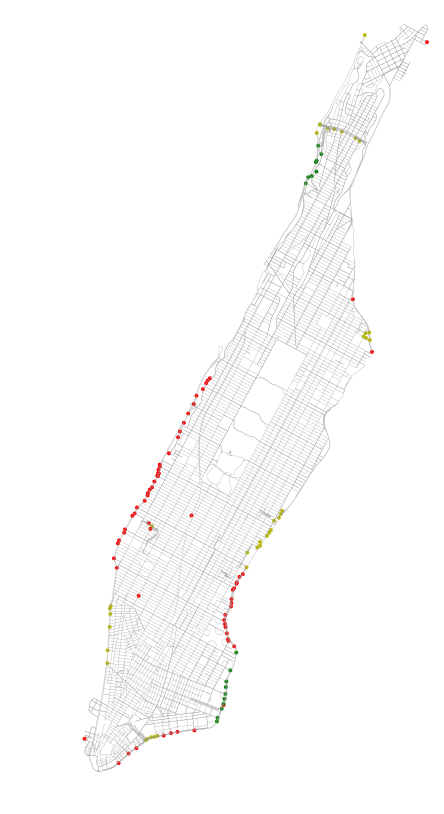

In [10]:
while True:
    try:
        # Putting our streaming data from the temporary table into a data frame
        df = sqlContext.sql("select * from traffic").toPandas()
        df.columns = ['id', 'Speed', 'Date', 'linkPoints', 'Borough']

        # Removing records not in current year/month/day
        # Traffic data sometimes incorrectly includes old records signifying a sensor error
        df['Date'] = pd.to_datetime(df['Date'])  # Converting time to datetime
        df = df[df['Date'].dt.year == datetime.now().year]
        df = df[df['Date'].dt.month == datetime.now().month]
        df = df[df['Date'].dt.day == datetime.now().day]

        # Merging in the nodes
        df['id'] = df['id'].astype(float)  # Converting for the merge
        df = df.merge(dfNodes, on ='id')

        # Mapping the nodes to speed categories
        df['Speed'] = df['Speed'].astype(float)
        slow = []
        medium = []
        fast = []
        for row in df.iterrows():
            speed = df['Speed'].ix[row]
            node = df['Node'].ix[row]
    
            # Speeds in MPH
            if speed >= 40:
                fast.append(node)
            if speed < 40 and speed >= 20:
                medium.append(node)
            if speed < 20:
                slow.append(node)
        
        # Setting the node color based on the speed categories
        nc = ['g' if node in fast
              else ('y' if node in medium
              else ('r' if node in slow 
              else 'None'))
              for node in manhattan_projected.nodes()]

        # Timestamp
        EST = datetime.utcnow() - timedelta(hours=5)  # Calculating Eastern Standard Time
        print('Plot Generated:\n {:%Y-%m-%d \n %H:%M:%S} EST'.format(EST))

        # Plotting the map
        fig, ax = ox.plot_graph(manhattan_projected, fig_height=10, node_size=8, 
                                node_alpha=1,edge_linewidth=0.2, dpi=100, node_color=nc)
        # Sets the output
        display.display(ax)
        display.clear_output(wait=True)
        
        time.sleep(microBatchSeconds)  # Number of seconds between refreshes
    
    except KeyboardInterrupt:
        break

Lastly, this final piece will terminate the streaming context

In [11]:
ssc.stop()

# Next Steps

No project is ever truly finished, so here are a few suggestions to improve either the visualization or this project for the future:

- Color edges instead of nodes
- Dynamically adjust node colors to deviation from mean of sensor speed
- Use a web socket instead of the web scraping script
- Expand to other NYC boroughs or other cities